In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import  accuracy_score,classification_report

In [2]:
Emotions = pd.read_csv('emotion.csv')

In [3]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(46728, 2377)

In [4]:
Y=Emotions['Emotions']
X= Emotions.drop('Emotions',axis= 1)

In [5]:
Y_class=Y.replace({'neutral':0,'happy':1,'sad':2,'angry':3, 'fear':4,'disgust':5,'surprise':6})

In [6]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y_class, random_state=35,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382,), (9346, 2376), (9346,))

In [7]:
# scale data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((37382, 2376), (37382,), (9346, 2376), (9346,))

In [8]:
import lightgbm as lgb
from sklearn import metrics

params = {
            'objective': 'multiclass',
            'boosting_type': 'gbdt',
            'num_class':7,
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.2,
            'max_depth':7,
            'reg_alpha':3,
            'reg_lambda':3,
            'n_estimators':1000,
        }
lgb_train = lgb.Dataset(x_train, label=y_train)
model = lgb.train(params, lgb_train, num_boost_round=200)




C:\Users\11732\.conda\envs\ML\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.783215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605690
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 2376
[LightGBM] [Info] Start training from score -1.881776
[LightGBM] [Info] Start training from score -1.837630
[LightGBM] [Info] Start training from score -1.838134
[LightGBM] [Info] Start training from score -1.831265
[LightGBM] [Info] Start training from score -1.841165
[LightGBM] [Info] Start training from score -1.832769
[LightGBM] [Info] Start training from score -2.984612
[Ligh

In [9]:
#训练集
y_pred_train = model.predict(x_train)
y_pred_train=np.argmax(y_pred_train,axis=1)

In [10]:

accuracy= accuracy_score(y_train, y_pred_train)
print(f"train Accuracy: {accuracy}")

train Accuracy: 0.9997592424161361


In [11]:
# 测试集上概率
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)

In [12]:
accuracy= accuracy_score(y_test, y_pred)
print(f"test Accuracy: {accuracy}")

test Accuracy: 0.7722020115557457


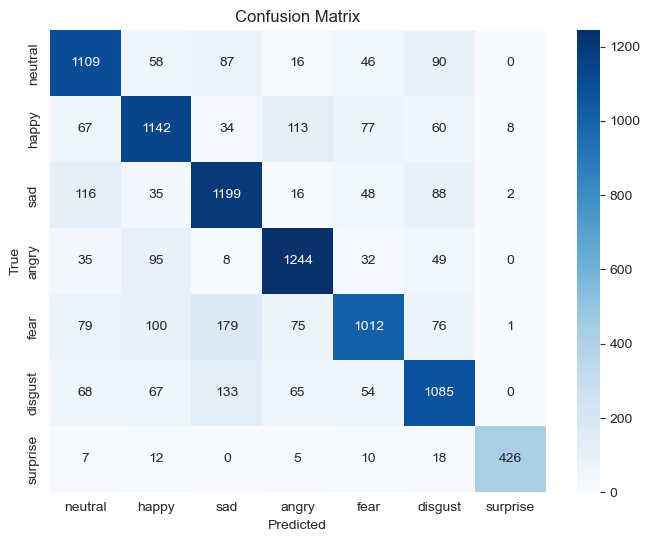

In [13]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
emotions=['neutral','happy','sad','angry', 'fear','disgust','surprise']
# 使用seaborn绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[i for i in emotions],
            yticklabels=[i for i in emotions])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1406
           1       0.76      0.76      0.76      1501
           2       0.73      0.80      0.76      1504
           3       0.81      0.85      0.83      1463
           4       0.79      0.66      0.72      1522
           5       0.74      0.74      0.74      1472
           6       0.97      0.89      0.93       478

    accuracy                           0.77      9346
   macro avg       0.79      0.78      0.79      9346
weighted avg       0.77      0.77      0.77      9346


## 网格调优

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# 定义参数范围
param_grid = {
    'num_leaves': [15, 31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.2, 0.5, 0.8],
    'max_depth': [6, 8, 10],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [0, 1, 10],
    'n_estimators': [100, 200, 500],
}

# 创建LightGBM分类器
lgb_classifier = lgb.LGBMClassifier(objective='multiclass', num_class=7)

# 使用GridSearchCV进行参数搜索
grid_search = GridSearchCV(lgb_classifier, param_grid, scoring='accuracy', cv=5)
grid_search.fit(x_train, y_train)

# 输出最佳参数
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# 使用最佳参数重新训练模型
best_params = grid_search.best_params_
best_lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=7, **best_params)
best_lgb_model.fit(x_train, y_train)

# 在测试集上评估性能
y_pred = best_lgb_model.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Test set accuracy with best parameters: {:.2f}".format(accuracy))


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605686
[LightGBM] [Info] Number of data points in the train set: 29905, number of used features: 2376
[LightGBM] [Info] Start training from score -1.881800
[LightGBM] [Info] Start training from score -1.837568
[LightGBM] [Info] Start training from score -1.838198
[LightGBM] [Info] Start training from score -1.831287
[LightGBM] [Info] Start training from score -1.841145
[LightGBM] [Info] Start training from score -1.832749
[LightGBM] [Info] Start training from score -2.984592
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ig